In [467]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [323]:
# Detect file encoding
with open('/Users/huyguy/Documents/Documents - Huy’s MacBook Pro/Projects/Forage/British Airline//Data/customer_booking.csv', 'rb') as f:
    result = chardet.detect(f.read())
result

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

In [324]:
booking = pd.read_csv('/Users/huyguy/Documents/Documents - Huy’s MacBook Pro/Projects/Forage/British Airline/Data/customer_booking.csv', encoding='ISO-8859-1')

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking


In [325]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [326]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

booking["flight_day"] = booking["flight_day"].map(mapping)

In [327]:
booking.booking_complete.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [328]:
booking.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [329]:
# Convert flight_day to int
booking.flight_day = booking.flight_day.astype('int')

In [330]:
# Apply one-hot encoding
booking = pd.get_dummies(booking, columns=['sales_channel', 'route', 'trip_type', 'booking_origin']) #No need drop first, model can handle correlated features

### Features and datasets for modeling

In [331]:
X = booking.drop('booking_complete', axis = 1)
y = booking.booking_complete
# Compute mutual information
mi = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'feature': X.columns, 'mi': mi})
# Get top 20 highest mutual information score features
mi_df_20 = mi_df.sort_values(ascending=False, by = 'mi').head(20)

In [332]:
# no_booking = booking[booking['Outcome'] == 1]
# yes_booking = booking[booking['Outcome'] == 0]
# undersampled_normal_data = resample(yes_booking,
#                                     n_samples=len(no_booking),  # Match the number of not booking
#                                     random_state=1234,  
#                                     replace=False)  # No replacement, to get an equal number

### Model 1 : Random forest classifier with top 20 features (Unbalanced)

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2202)

In [334]:
# Modeling features
features = list(mi_df_20.feature.values)
# Random forest classifer
rf_20 = RandomForestClassifier(n_estimators = 100, random_state= 2202)
rf_20.fit(X_train[features], y_train)
y_pred = rf_20.predict(X_test[features])

In [335]:
# Accuracy
rf_20_accuracy = accuracy_score(y_test, y_pred)
rf_20_accuracy

0.829

In [336]:
# Perform 5-fold cross-validation
rf_20_cv_scores = cross_val_score(rf_20, X_train[features], y_train, cv=5, scoring='accuracy')
rf_20_cv_scores.mean()

0.8217000000000001

In [337]:
# Trade-off between true positive rate (recall) and false positive rate
rf_20_roc_auc = roc_auc_score(y_test, rf_20.predict_proba(X_test[features])[:, 1])
rf_20_roc_auc

0.6798730533713375

In [338]:
rf_20_report = classification_report(y_test, y_pred, output_dict=True) # Return dict to transform into dataframe
rf_20_report = pd.DataFrame(rf_20_report).T
rf_20_report

,precision,recall,f1-score,support
0,0.871909,0.937463,0.903499,8539.000
1,0.347985,0.195072,0.250000,1461.000
accuracy,0.829000,0.829000,0.829000,0.829
macro avg,0.609947,0.566268,0.576749,10000.000
weighted avg,0.795364,0.829000,0.808023,10000.000


### Model 2 : Random forest classifier with all features (Unbalanced)

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2202)

In [340]:
# Random forest classifer
rf = RandomForestClassifier(n_estimators = 100, random_state= 2202)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [341]:
# Accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
rf_accuracy

0.8552

In [342]:
# Perform 5-fold cross-validation
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
rf_cv_scores.mean()

0.8486749999999998

In [343]:
# Trade-off between true positive rate (recall) and false positive rate
rf_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_roc_auc

0.7810902891985148

In [344]:
rf_report = classification_report(y_test, y_pred, output_dict=True) # Return dict to transform into dataframe
rf_report = pd.DataFrame(rf_report).T
rf_report

,precision,recall,f1-score,support
0,0.869901,0.976461,0.920106,8539.0000
1,0.515663,0.146475,0.228145,1461.0000
accuracy,0.855200,0.855200,0.855200,0.8552
macro avg,0.692782,0.561468,0.574125,10000.0000
weighted avg,0.818147,0.855200,0.819010,10000.0000


### Model 3 : Random forest classifier with top 20 features (Balanced)

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2202)
features = list(mi_df_20.feature.values)
smote = SMOTE(random_state=2202)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train[features], y_train)

In [346]:
# Random forest classifer
rf_20_bl = RandomForestClassifier(n_estimators = 100, random_state= 2202)
rf_20_bl.fit(X_train_resampled, y_train_resampled)
y_pred = rf_20_bl.predict(X_test[features])

In [347]:
# Accuracy
rf_20_bl_accuracy = accuracy_score(y_test, y_pred)
rf_20_bl_accuracy

0.7606

In [348]:
# Perform 5-fold cross-validation
rf_20_bl_cv_scores = cross_val_score(rf_20_bl, X_train[features], y_train, cv=5, scoring='accuracy')
rf_20_bl_cv_scores.mean()

0.8217000000000001

In [349]:
# Trade-off between true positive rate (recall) and false positive rate
rf_20_bl_roc_auc = roc_auc_score(y_test, rf_20_bl.predict_proba(X_test[features])[:, 1])
rf_20_bl_roc_auc

0.665138068045323

In [350]:
rf_20_bl_report = classification_report(y_test, y_pred, output_dict=True) # Return dict to transform into dataframe
rf_20_bl_report = pd.DataFrame(rf_20_bl_report).T
rf_20_bl_report

,precision,recall,f1-score,support
0,0.885073,0.827029,0.855067,8539.0000
1,0.269174,0.372348,0.312464,1461.0000
accuracy,0.760600,0.760600,0.760600,0.7606
macro avg,0.577123,0.599688,0.583766,10000.0000
weighted avg,0.795090,0.760600,0.775793,10000.0000


### Model 4 : Random forest classifier with all features (Balanced)

In [458]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2202)
smote = SMOTE(random_state=2202)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [459]:
# Random forest classifer
rf_bl = RandomForestClassifier(n_estimators = 100, random_state= 2202, class_weight='balanced')
rf_bl.fit(X_train_resampled, y_train_resampled)
y_pred = rf_bl.predict(X_test)

In [460]:
# Accuracy
rf_bl_accuracy = accuracy_score(y_test, y_pred)
rf_bl_accuracy

0.8439

In [461]:
# Perform 5-fold cross-validation
rf_bl_cv_scores = cross_val_score(rf_bl, X_train, y_train, cv=5, scoring='accuracy')
rf_bl_cv_scores.mean()

0.849475

In [462]:
# Trade-off between true positive rate (recall) and false positive rate
rf_bl_roc_auc = roc_auc_score(y_test, rf_bl.predict_proba(X_test)[:, 1])
rf_bl_roc_auc

0.7796880584705403

In [463]:
rf_bl_report = classification_report(y_test, y_pred, output_dict=True) # Return dict to transform into dataframe
rf_bl_report = pd.DataFrame(rf_bl_report).T
rf_bl_report

,precision,recall,f1-score,support
0,0.879322,0.947184,0.911992,8539.0000
1,0.437656,0.240246,0.310208,1461.0000
accuracy,0.843900,0.843900,0.843900,0.8439
macro avg,0.658489,0.593715,0.611100,10000.0000
weighted avg,0.814794,0.843900,0.824071,10000.0000


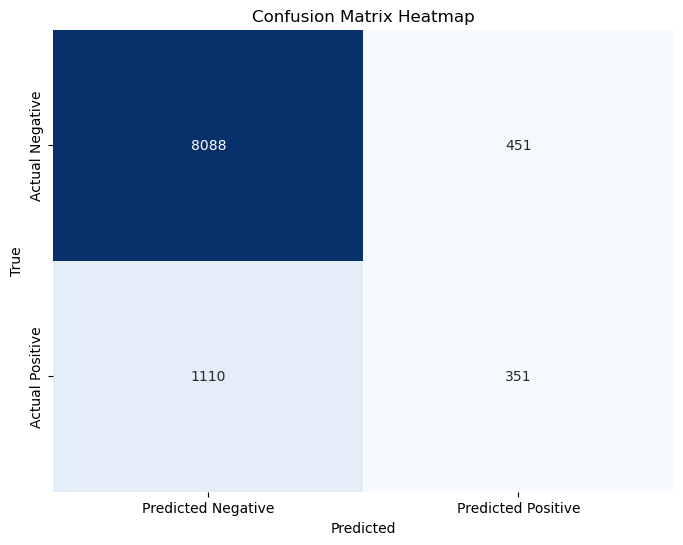

In [464]:
cm = confusion_matrix(y_test, y_pred)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the image after the plot is shown
fig = plt.gcf()  # Get the current figure
fig.savefig("Confusion Matrix.jpg", format='jpg')

plt.show()

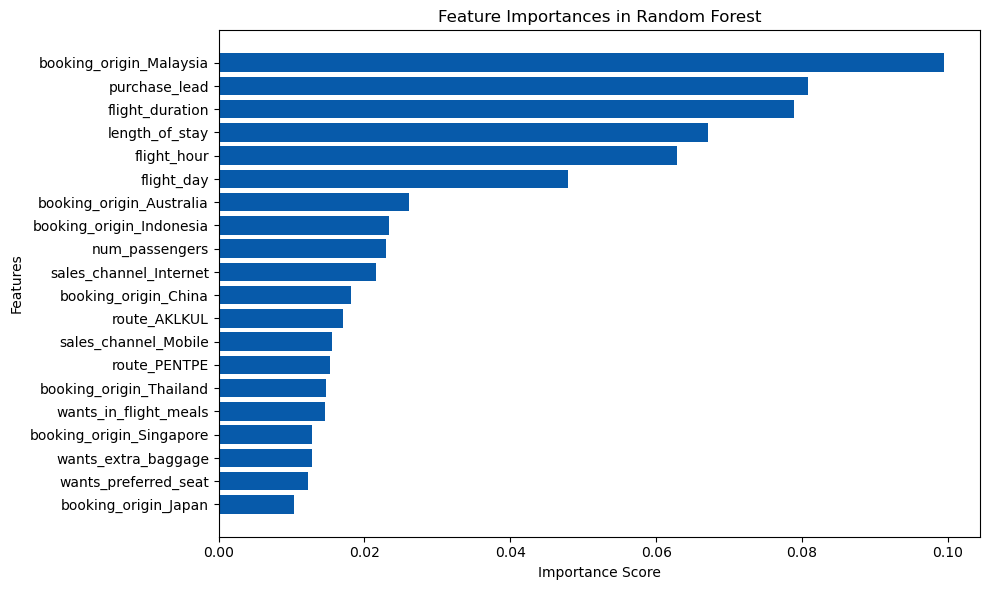

In [446]:
importances = rf_bl.feature_importances_
# Create a DataFrame for better readability
feature_importances = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='#075aaa')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
# Save the image after the plot is shown
fig = plt.gcf()  # Get the current figure
fig.savefig("Feature Importances.jpg", format='jpg')

plt.show()

Based on the four models above, utilizing all features results in higher scores across all metrics. Balancing the data improves the prediction of customers who did not complete their booking, though it slightly reduces overall accuracy. Since the goal is to predict customers who fail to complete their booking, Model 4 appears to be the most suitable for this task.

In [ ]:
#

### Model 5 : XGBoost with all features

In [454]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2202)

In [455]:
# Calculate scale_pos_weight
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

In [456]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [414]:
# Accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.7029

In [415]:
# Perform 5-fold cross-validation
xgb_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
xgb_cv_scores.mean()

0.7056250000000001

In [416]:
# Trade-off between true positive rate (recall) and false positive rate
xgb_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
xgb_roc_auc

0.7895768972077145

In [417]:
xgb_report = classification_report(y_test, y_pred, output_dict=True) # Return dict to transform into dataframe
xgb_report = pd.DataFrame(xgb_report).T
xgb_report

,precision,recall,f1-score,support
0,0.941624,0.695163,0.799838,8539.0000
1,0.295725,0.748118,0.423890,1461.0000
accuracy,0.702900,0.702900,0.702900,0.7029
macro avg,0.618675,0.721641,0.611864,10000.0000
weighted avg,0.847258,0.702900,0.744912,10000.0000


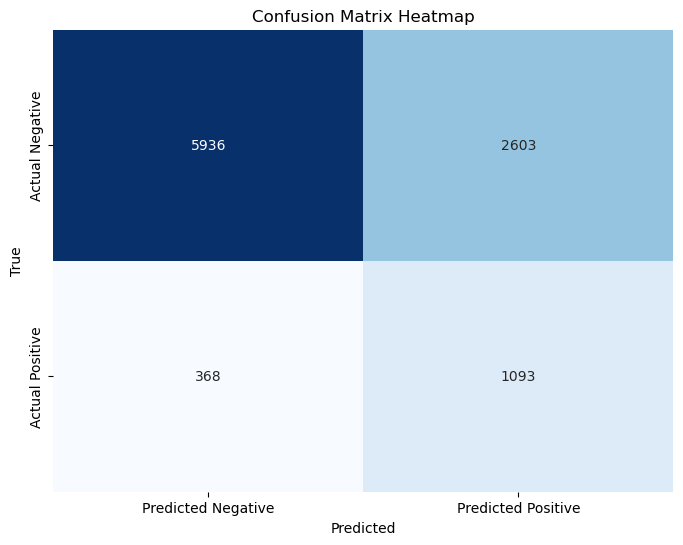

In [457]:
cm = confusion_matrix(y_test, y_pred)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the image after the plot is shown
fig = plt.gcf()  # Get the current figure
fig.savefig("Confusion Matrix.jpg", format='jpg')

plt.show()

Model 5 outperforms Model 4 in recall and F1-score for Case 1, but has a lower precision score and accuracy. The choice between models depends on which metric is prioritized.

### Summary

In [419]:
summary = {'Model': ['Random Forest 20 Unbalanced', 'Random Forest All Unbalanced', 'Random Forest 20 Balanced', 'Random Forests All Balanced', 'XGBoost All Balanced'],
           'Accuracy': [rf_20_accuracy, rf_accuracy, rf_20_bl_accuracy, rf_bl_accuracy, xgb_accuracy],
           'Cross-Validation Accuracy': [rf_20_cv_scores.mean(), rf_cv_scores.mean(), rf_20_bl_cv_scores.mean(), rf_bl_cv_scores.mean(), xgb_cv_scores.mean()],
           'Testing AUC' : [rf_20_roc_auc, rf_roc_auc, rf_20_bl_roc_auc, rf_bl_roc_auc, xgb_roc_auc]
}
summary = pd.DataFrame(summary)
summary

,Model,Accuracy,Cross-Validation Accuracy,Testing AUC
0,Random Forest 20 Unbalanced,0.8290,0.821700,0.679873
1,Random Forest All Unbalanced,0.8552,0.848675,0.781090
2,Random Forest 20 Balanced,0.7606,0.821700,0.665138
3,Random Forests All Balanced,0.8439,0.848675,0.779688
4,XGBoost All Balanced,0.7029,0.705625,0.789577


### Model 6 : Balanced Random Forest Classifier with all features

In [492]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2202)

In [493]:
brf = BalancedRandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=2202)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)

In [494]:
brf_report = classification_report(y_test, y_pred, output_dict=True)
brf_report = pd.DataFrame(brf_report).T
brf_report

,precision,recall,f1-score,support
0,0.935565,0.743061,0.828275,8539.0000
1,0.318210,0.700890,0.437700,1461.0000
accuracy,0.736900,0.736900,0.736900,0.7369
macro avg,0.626887,0.721976,0.632988,10000.0000
weighted avg,0.845369,0.736900,0.771212,10000.0000


In [495]:
brf_accuracy = accuracy_score(y_test, y_pred)
brf_accuracy

0.7369

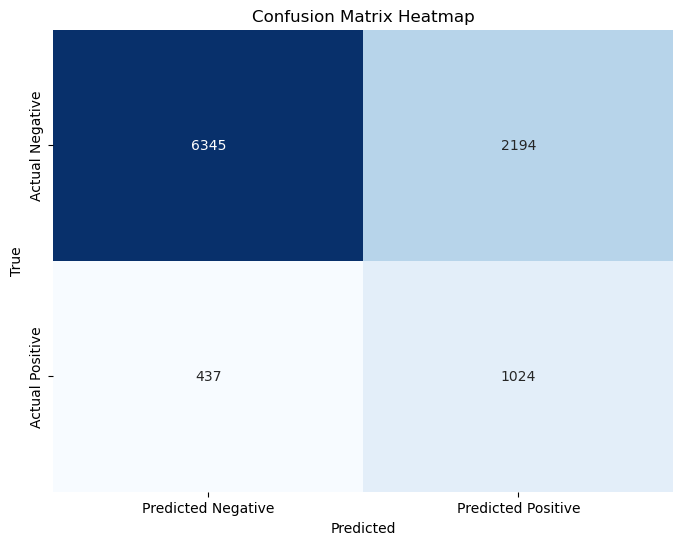

In [496]:
cm = confusion_matrix(y_test, y_pred)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the image after the plot is shown
# fig = plt.gcf()  # Get the current figure
# fig.savefig("Confusion Matrix.jpg", format='jpg')

plt.show()